In [47]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
#from pyAgrum.lib.pretty_print import pretty_cpt

from IPython.display import display, Math, Latex

import pandas
import numpy as np
import matplotlib
import pyAgrum.lib.bn2roc as bn2roc
%matplotlib inline

# Exercice 7
> From Roland Donnat

L'objectif de cet exercice est d'utiliser un RB afin de prédire le résultat de matchs de football de Ligue 1 (division 1 de football en France) à partir de certaines statistiques de jeu.

Deux jeux de données vont être utilisés :

+ Un jeu de données d'apprentissage permettant de calibrer le modèle prédictif contanant l'historique des matchs des saisons 2005-2006 à 2009-2010 - Fichier fra_l1_app.csv
+ Un jeu de données de test permettant d'évaluer le modèle contanant les matchs des saisons 2010-2011 et 2011-201 - Fichier fra_l1_test.csv



### Prétraitement des données

Pour un apprentissage "facile", nous allons :
+ transformer toutes les données en entier ou chaîne, 
+ s'assurer que la base de tests ne possèdent pas de valeurs inconnues pour la base d'apprentissage
+ sélectionner les variables "HomeTeam","AwayTeam","HST","AST" qui nous serviront à tenter de prédire "FTR" 
+ créer les fichiers "learn.csv" et "test.csv" épurés.

In [2]:
# data file is in the ../resources folder

datas=pandas.read_csv("fra_l1_app.csv")
tests=pandas.read_csv("fra_l1_test.csv")

In [3]:
datas.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HY,AY,HR,AR
0,2005-07-29,Paris SG,Metz,4,1,H,2,0,H,16,11,9,7,2,3,0,0
1,2005-07-30,Marseille,Bordeaux,0,2,A,0,1,A,7,9,3,4,2,4,1,0
2,2005-07-30,Nancy,Monaco,0,1,A,0,0,D,10,5,6,3,2,2,2,0
3,2005-07-30,Nantes,Lens,2,0,H,2,0,H,10,10,3,3,1,3,0,0
4,2005-07-30,Nice,Troyes,1,1,D,1,0,H,13,5,6,5,2,2,0,1


In [4]:
tests.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HY,AY,HR,AR
0,2010-08-07,Lyon,Monaco,0,0,D,0,0,D,16,9,5,4,2,3,0,0
1,2010-08-07,Marseille,Caen,1,2,A,0,0,D,16,12,3,2,2,3,0,0
2,2010-08-07,Nice,Valenciennes,0,0,D,0,0,D,10,11,2,1,0,3,0,0
3,2010-08-07,Paris SG,St Etienne,3,1,H,2,1,H,19,14,6,5,2,1,0,0
4,2010-08-07,Rennes,Lille,1,1,D,1,0,H,20,14,5,5,3,3,0,0


### Prétraitement

L'apprentissage avec pyAgrum fonctionne sur des csv totalement prétraités (des entiers). Il s'agit donc de préparer la base en ce sens.

In [5]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 1898
Data columns (total 17 columns):
Date        1899 non-null object
HomeTeam    1899 non-null object
AwayTeam    1899 non-null object
FTHG        1899 non-null int64
FTAG        1899 non-null int64
FTR         1899 non-null object
HTHG        1899 non-null int64
HTAG        1899 non-null int64
HTR         1899 non-null object
HS          1899 non-null float64
AS          1899 non-null float64
HST         1899 non-null float64
AST         1899 non-null float64
HY          1899 non-null int64
AY          1899 non-null int64
HR          1899 non-null int64
AR          1899 non-null int64
dtypes: float64(4), int64(8), object(5)
memory usage: 267.0+ KB


In [6]:
#pretraitement

# float en int
datas["HS"] = datas["HS"].astype(int)
datas["AS"] = datas["AS"].astype(int)
tests["HS"] = tests["HS"].astype(int)
tests["AS"] = tests["AS"].astype(int)
datas["HST"] = datas["HST"].astype(int)
datas["AST"] = datas["AST"].astype(int)
tests["HST"] = tests["HST"].astype(int)
tests["AST"] = tests["AST"].astype(int)
    
# s'assurer que les valeurs de tests sont incluses dans les valeurs d'apprentissage
HST_app_max = np.max(datas["HST"])
AST_app_max = np.max(datas["AST"])
tests.loc[tests["HST"] > HST_app_max, "HST"] = HST_app_max
tests.loc[tests["AST"] > AST_app_max, "AST"] = AST_app_max

# ville -> entiers
towns = datas['HomeTeam'].unique()
towns2nums = dict(zip(towns,range(len(towns))))
nums2towns = dict(zip(range(len(towns)),towns))
datas['HomeTeamNum']=datas['HomeTeam'].replace(towns2nums)
datas['AwayTeamNum']=datas['AwayTeam'].replace(towns2nums)
tests['HomeTeamNum']=tests['HomeTeam'].replace(towns2nums)
tests['AwayTeamNum']=tests['AwayTeam'].replace(towns2nums)

# classe -> entiers
classes=datas['FTR'].unique()
classes2nums=dict(zip(classes,range(len(classes))))
datas['FTRNum']=datas['FTR'].replace(classes2nums)
tests['FTRNum']=tests['FTR'].replace(classes2nums)

datas.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HY,AY,HR,AR,HomeTeamNum,AwayTeamNum,FTRNum
0,2005-07-29,Paris SG,Metz,4,1,H,2,0,H,16,11,9,7,2,3,0,0,0,16,0
1,2005-07-30,Marseille,Bordeaux,0,2,A,0,1,A,7,9,3,4,2,4,1,0,1,14,1
2,2005-07-30,Nancy,Monaco,0,1,A,0,0,D,10,5,6,3,2,2,2,0,2,11,1
3,2005-07-30,Nantes,Lens,2,0,H,2,0,H,10,10,3,3,1,3,0,0,3,13,0
4,2005-07-30,Nice,Troyes,1,1,D,1,0,H,13,5,6,5,2,2,0,1,4,12,2


In [7]:
tests.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HY,AY,HR,AR,HomeTeamNum,AwayTeamNum,FTRNum
0,2010-08-07,Lyon,Monaco,0,0,D,0,0,D,16,9,5,4,2,3,0,0,17,11,2
1,2010-08-07,Marseille,Caen,1,2,A,0,0,D,16,12,3,2,2,3,0,0,1,23,1
2,2010-08-07,Nice,Valenciennes,0,0,D,0,0,D,10,11,2,1,0,3,0,0,4,21,2
3,2010-08-07,Paris SG,St Etienne,3,1,H,2,1,H,19,14,6,5,2,1,0,0,0,6,0
4,2010-08-07,Rennes,Lille,1,1,D,1,0,H,20,14,5,5,3,3,0,0,18,8,2


Dans un second temps, nous décidons de nous limiter aux variables sivantes :
+ features : "HomeTeamNum","AwayTeamNum","HST","AST"
+ classe : "FTRNum"

In [8]:
#variables selection
#HomeTeam = Equipe a domicile
#AwayTeam = Equipe a l'exterieur
#HST = Home Team Shots on Targe = Tirs cadrés de l'equipe a domicile
#AST = Away Team Shots on Target = Tirs cadrés de l'equipe a l'exterieur
#FTR = Full Time Result (H = Home Win, D = Draw, A = Away Win) = Score final
vars=["HomeTeamNum","AwayTeamNum","HST","AST","FTRNum"]

#sauvegarde des bases opérationnelles 
datas[vars].to_csv("learn.csv",index=False)
tests[vars].to_csv("test.csv",index=False)

In [9]:
new_datas=pandas.read_csv("learn.csv")
new_tests=pandas.read_csv("test.csv")

In [10]:
new_datas.head()

,HomeTeamNum,AwayTeamNum,HST,AST,FTRNum
0,0,16,9,7,0
1,1,14,3,4,1
2,2,11,6,3,1
3,3,13,3,3,0
4,4,12,6,5,2


In [11]:
new_tests.head()

,HomeTeamNum,AwayTeamNum,HST,AST,FTRNum
0,17,11,5,4,2
1,1,23,3,2,1
2,4,21,2,1,2
3,0,6,6,5,0
4,18,8,5,5,2


## Modèle "Naive Bayes"
Nous essayons tout d'abord un modèle "Naïve Bayes" qui est connu pour ne pas être correct du tout théoriquement mais, finalement, pour assez bien fonctionner. Le principe du modèle est de supposer une structure du modèle où la variable à expliquer (la classe) est l'unique parents des variables explicantes (les features).

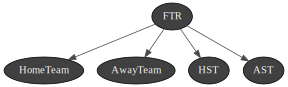

In [13]:
naive=gum.BayesNet()

H=naive.add(gum.LabelizedVariable("HomeTeam","HomeTeamNum",list(map(str,np.unique(new_datas["HomeTeamNum"].values)))))
A=naive.add(gum.LabelizedVariable("AwayTeam","AwayTeamNum",list(map(str,np.unique(new_datas["AwayTeamNum"].values)))))
HST=naive.add(gum.LabelizedVariable("HST","HST",list(map(str,np.unique(new_datas["HST"].values)))))
AST=naive.add(gum.LabelizedVariable("AST","AST",list(map(str,np.unique(new_datas["AST"].values)))))
FTR=naive.add(gum.LabelizedVariable("FTR","FTRNum",list(map(str,np.unique(new_datas["FTRNum"].values)))))

naive.addArc(FTR,H)
naive.addArc(FTR,A)
naive.addArc(FTR,HST)
naive.addArc(FTR,AST)

gnb.showBN(naive)

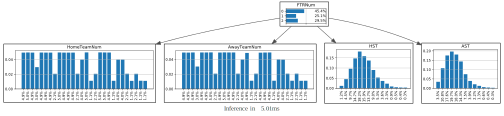

In [15]:
learner=gum.BNLearner("learn.csv")
learner.useScoreBIC()
learner.useAprioriSmoothing(1)
naive=learner.learnParameters(naive.dag())
gnb.showInference(naive)

In [23]:
print("Dictionnaire equipes :\n")
print(nums2towns)
print("\nDictionnaire FTR :\n")
print(classes2nums)

Dictionnaire equipes :

{0: 'Paris SG', 1: 'Marseille', 2: 'Nancy', 3: 'Nantes', 4: 'Nice', 5: 'Sochaux', 6: 'St Etienne', 7: 'Strasbourg', 8: 'Lille', 9: 'Le Mans', 10: 'Toulouse', 11: 'Monaco', 12: 'Troyes', 13: 'Lens', 14: 'Bordeaux', 15: 'Ajaccio', 16: 'Metz', 17: 'Lyon', 18: 'Rennes', 19: 'Auxerre', 20: 'Sedan', 21: 'Valenciennes', 22: 'Lorient', 23: 'Caen', 24: 'Le Havre', 25: 'Grenoble', 26: 'Montpellier', 27: 'Boulogne'}

Dictionnaire FTR :

{'D': 2, 'A': 1, 'H': 0}


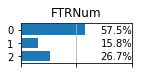

In [42]:
gnb.showPosterior(naive,target='FTRNum',evs={'HomeTeamNum':1,'AwayTeamNum':0})

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-0.png


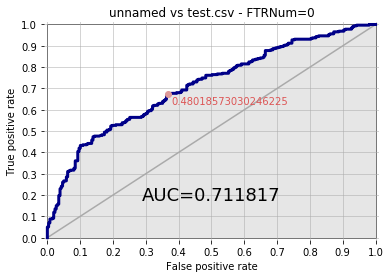

In [53]:
bn2roc.showROC(naive,"test.csv",variable="FTRNum",label="0")

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-1.png


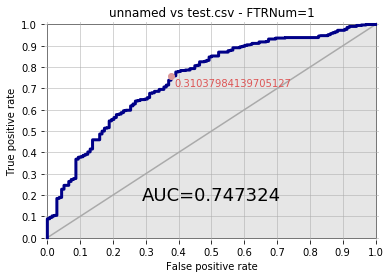

In [44]:
bn2roc.showROC(naive,"test.csv",variable="FTRNum",label="1")

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-2.png


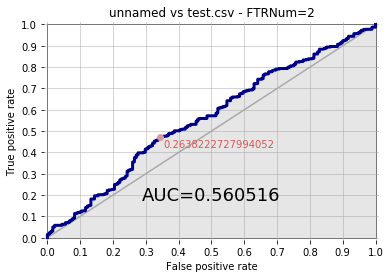

In [45]:
bn2roc.showROC(naive,"test.csv",variable="FTRNum",label="2")

## Apprentissage 

Un apprentissage de structure peut-il donner mieux pour notre problème ?

Learned in 0.001169097s


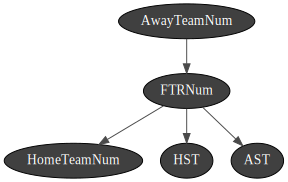

In [58]:
learner=gum.BNLearner("learn.csv")
learner.useLocalSearchWithTabuList()
learner.useScoreAIC()
learner.useNoApriori()
model=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(model)

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-0.png


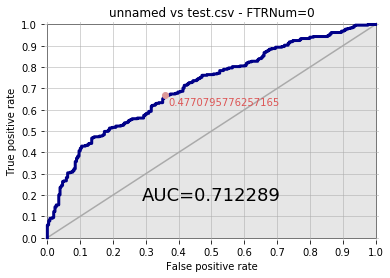

In [59]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="0")

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-1.png


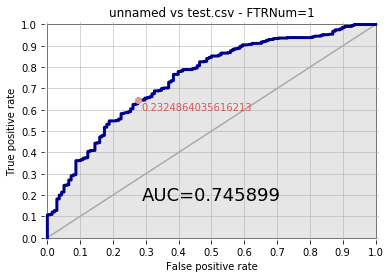

In [60]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="1")

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-2.png


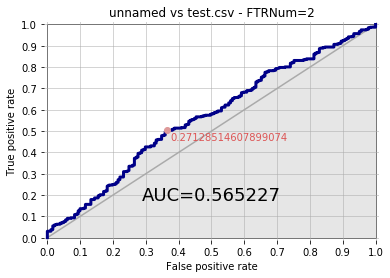

In [61]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="2")

Learned in 0.0021998570000000004s


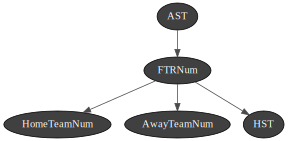

In [72]:
learner=gum.BNLearner("learn.csv")
learner.useGreedyHillClimbing()
learner.useScoreAIC()
learner.useNoApriori()
model=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(model)

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-0.png


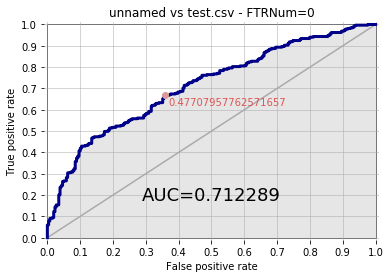

In [73]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="0")

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-1.png


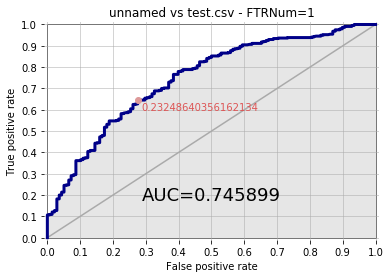

In [74]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="1")

 test.csv : [ ################################################################ ] 100%
 result in test.csv-ROC_unnamed-FTRNum-2.png


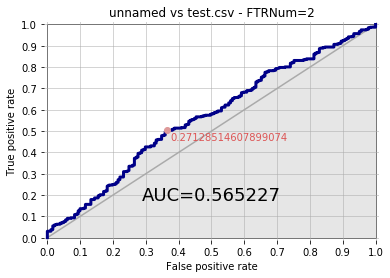

In [75]:
bn2roc.showROC(model,"test.csv",variable="FTRNum",label="2")

En déterminant la structure du réseau bayésien par apprentissage, on obtient des résultats légèrement meilleurs : les modèles appris arrivent mieux à prédire/reconnaître les classes 0 et 2 que le Naive Bayes (qui reste meilleur en ce qui concerne la reconnaissance de la classe 1). 